<a href="https://colab.research.google.com/github/biswa-13/TensorFlow-Practice/blob/master/TF6_NLP_LSTM_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This will demostrate the step by step procedure for implementing the NLP for SentimentnAnalysis using the LongShort Term Memory mechanism.<br/>
Reference: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c02_nlp_multiple_models_for_predicting_sentiment.ipynb#scrollTo=3N6Zul47PMED

https://classroom.udacity.com/courses/ud187/lessons/52b95146-ddb7-471c-9237-20fb24d25237/concepts/001cc073-b837-425d-98be-64c231a6eb9d

In [0]:
# - importing the required libraries

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("Finish - importing the required libraries")

In [0]:
# - declaring the required variables

vaocab_len = 1000
max_len = 10
padding = "pre"
truncating = "pre"
embed_dim = 16
epochs = 200
dataset_name = 'glue/sst2'
oovToken = "<OOV>"
print("Finish - declaring the required variables")

In [0]:
# - load dataset 
dataset, dataset_info = tfds.load(dataset_name, with_info= True)
print("dataset_info -->",dataset_info)

print("Finish - load dataset")

In [0]:
# - Prapare the training and testing data
dataset_train, dataset_validation = dataset['train'], dataset['validation']
print("dataset_train info-->", dataset_train)
print("dataset_validation info-->", dataset_validation)
dataset_train_seneteces = []
dataset_train_labels = []
dataset_val_sentneces = []
dataset_val_labels = []

# we are going to take only the 10000 items from the dataset_train by using the take(10000)
for data in dataset_train.take(10000):
  text, label = data["sentence"], data["label"]
  dataset_train_seneteces.append(str(text.numpy()))
  dataset_train_labels.append(label.numpy())

print("dataset_train_seneteces length -->",len(dataset_train_seneteces), ", dataset_train_labels length -->", len(dataset_train_labels))

# we are going to take all the validation dataset by using the take(-1)
for val_data in dataset_validation.take(-1):
  val_text, val_label = val_data["sentence"], val_data["label"]
  dataset_val_sentneces.append(str(val_text.numpy()))
  dataset_val_labels.append(val_label.numpy())

print("dataset_val_sentneces length -->",len(dataset_val_sentneces), ", dataset_val_labels length -->", len(dataset_val_labels))

print("Finish - Prapare the training and testing data")

In [0]:
# - Tokenizing, Sequencing and Padding the train and validation dataset

# -- tokenizing the words
tokenizer = Tokenizer(num_words= vaocab_len, oov_token= oovToken)
tokenizer.fit_on_texts(dataset_train_seneteces)
word_index = tokenizer.word_index

# -- sequencing the words
dataset_train_sequence = tokenizer.texts_to_sequences(dataset_train_seneteces)
dataset_test_sequence = tokenizer.texts_to_sequences(dataset_val_sentneces)

dataset_train_padding =  pad_sequences(dataset_train_sequence, maxlen= max_len, padding= padding, truncating= truncating)
dataset_val_padding = pad_sequences(dataset_test_sequence, maxlen= max_len, padding= padding, truncating= truncating)

dataset_train_labels_final = np.array(dataset_train_labels)
dataset_val_labels_final = np.array(dataset_val_labels)

print("Finish - Tokenizing, Sequencing and Padding the train and validation dataset")

In [26]:
# - defining the callback function which will check the validation accuracy after each epoch and if it founds no improvement in the training then it will stop the training procedure

# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
model_callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=3)

print("Finish - defining the callback function for model training")

Finish - defining the callback function for model training


In [0]:
# - implemeting a generic function to plot the training graph of the models
def plot_graph(history, string):
   plt.plot(history.history[string])
   plt.plot(history.history["val_"+string])
   plt.xlabel("epochs")
   plt.ylabel(string)
   plt.legend([string, "val_"+string])
   plt.show()

print("Finish - implemeting a generic function to plot the training graph of the models")

In [0]:
# - Creating and Training a model using the Embedding layer

# -- build the model
embed_sentiment_model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim= vaocab_len, output_dim= embed_dim, input_length= max_len ),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

# -- compile the model
embed_sentiment_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
embed_sentiment_model.summary()

embed_model_history =  embed_sentiment_model.fit(dataset_train_padding, dataset_train_labels_final, epochs= epochs, 
                                                 validation_data=(dataset_val_padding, dataset_val_labels_final),
                                                 callbacks= [model_callback]
                                                 )

embed_sentiment_model.save("embed_sentiment_model.h5")



print("Finish - Creating and Training  a model using the Embedding layer")


Training Stopped at-  41 out of 200 epochs.


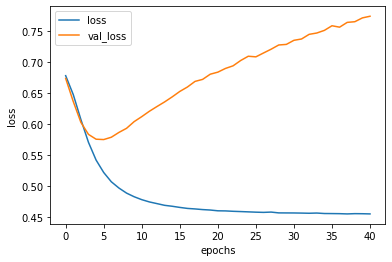

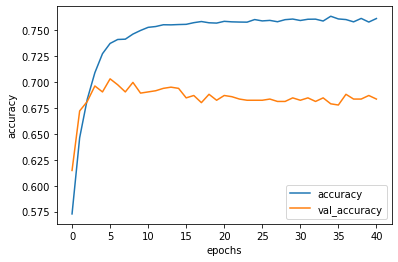

In [32]:
print("Training Stopped at- ", len(embed_model_history.history['loss']), "out of 200 epochs.")
plot_graph(embed_model_history, "loss")
plot_graph(embed_model_history, "accuracy")

In [0]:
# - Creating and Training a model using the Embeding with Convolutional layer

# -- building the model
cnn_sentiment_model = tf.keras.Sequential([
                                           tf.keras.layers.Embedding(input_dim= vaocab_len, output_dim= embed_dim, input_length= max_len),
                                           tf.keras.layers.Conv1D(16,5, activation='relu'),
                                           tf.keras.layers.GlobalAveragePooling1D(),
                                           tf.keras.layers.Dense(1, activation='sigmoid')
])

# -- compiling the model
cnn_sentiment_model.compile(loss= "binary_crossentropy", optimizer='adam', metrics=['accuracy'])
cnn_sentiment_model.summary()

# -- training the model
cnn_model_history =  cnn_sentiment_model.fit(dataset_train_padding, dataset_train_labels_final, epochs= epochs,
                                             validation_data=(dataset_val_padding, dataset_val_labels_final), callbacks= [model_callback])

cnn_sentiment_model.save("cnn_sentiment_model.h5")



print("Finish - Creating and Training a model using the Embeding with Convolutional layer")

In [0]:
print("Training Stopped at- ", len(cnn_model_history.history['loss']), "out of 200 epochs.")
plot_graph(cnn_model_history, 'accuracy')
plot_graph(cnn_model_history, 'loss')

In [0]:
# - Creating and Training a model using the Embeding with GRU layer

# -- building the model

gru_sentiment_model = tf.keras.Sequential([
                                           tf.keras.layers.Embedding(input_dim= vaocab_len, output_dim= embed_dim, input_length= max_len),
                                           tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                                           tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
# -- compiling the model
gru_sentiment_model.compile(loss= "binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
gru_sentiment_model.summary

# -- trainging the model
gru_model_history = gru_sentiment_model.fit(dataset_train_padding, dataset_train_labels_final, epochs= epochs, 
                                            validation_data=(dataset_val_padding, dataset_val_labels_final), callbacks= [model_callback])

gru_sentiment_model.save("gru_sentiment_model.h5")


print("Finish - Creating and Training a model using the Embeding with GRU layer")

Training Stopped at-  20 out of 200 epochs.


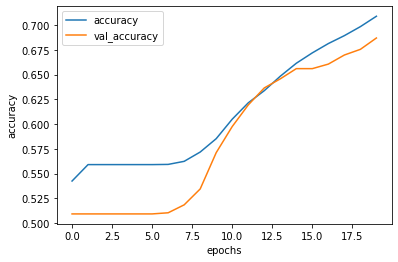

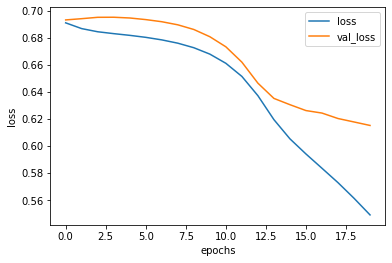

In [28]:
print("Training Stopped at- ", len(gru_model_history.history['loss']), "out of 200 epochs.")
plot_graph(gru_model_history, 'accuracy')
plot_graph(gru_model_history, 'loss')

In [0]:
# - Creating and Training a model using the Embeding with LSTM layer

# -- building the model
lstm_sentiment_model = tf.keras.Sequential([
                                            tf.keras.layers.Embedding(input_dim= vaocab_len, output_dim= embed_dim, input_length= max_len),
                                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim)), 
                                            tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
# -- compiling the model
# lstm_sentiment_model.compile(loss= "binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
lstm_sentiment_model.compile(loss= "binary_crossentropy", optimizer= 'adam', metrics=['accuracy'])
lstm_sentiment_model.summary

# -- trainging the model
lstm_model_history = lstm_sentiment_model.fit(dataset_train_padding, dataset_train_labels_final, epochs= epochs,
                                              validation_data=(dataset_val_padding, dataset_val_labels_final), callbacks= [model_callback])

lstm_sentiment_model.save("lstm_sentiment_model.h5")


print("Finish - Creating and Training a model using the Embeding with LSTM layer")

Training Stopped at-  56 out of 200 epochs.


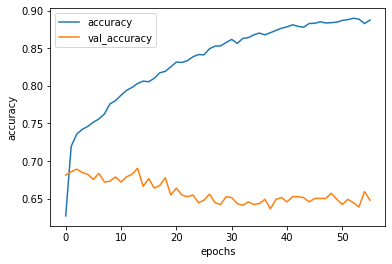

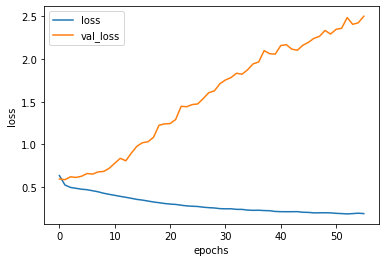

In [30]:
print("Training Stopped at- ", len(lstm_model_history.history['loss']), "out of 200 epochs.")
plot_graph(lstm_model_history, 'accuracy')
plot_graph(lstm_model_history, 'loss')

In [0]:
# - Creating and Training a model using the Embeding with multiple LSTM layer


# -- building the model
lstm_multi_sentiment_model = tf.keras.Sequential([
                                            tf.keras.layers.Embedding(input_dim= vaocab_len, output_dim= embed_dim, input_length= max_len),
                                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim, return_sequences=True)), 
                                            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embed_dim)),
                                            tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
# -- compiling the model
# lstm_sentiment_model.compile(loss= "binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
lstm_multi_sentiment_model.compile(loss= "binary_crossentropy", optimizer= 'adam', metrics=['accuracy'])
lstm_multi_sentiment_model.summary

# -- trainging the model
lstm_multi_model_history = lstm_multi_sentiment_model.fit(dataset_train_padding, dataset_train_labels_final, 
                                                          epochs= 200, validation_data=(dataset_val_padding, dataset_val_labels_final),
                                                          callbacks=[model_callback]
                                                          )

lstm_multi_sentiment_model.save("lstm_multi_sentiment_model.h5")


print("Finish - Creating and Training a model using the Embeding with multiple LSTM layer")

Training Stopped at-  68 out of 200 epochs.


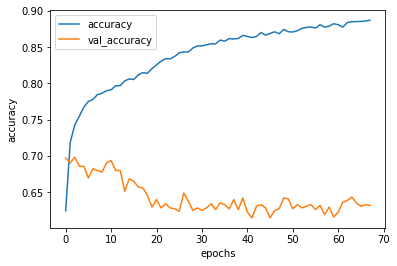

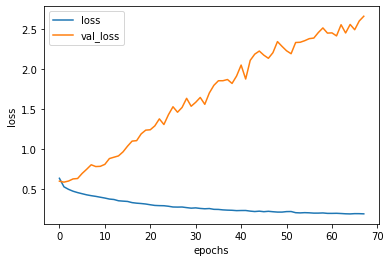

In [33]:
print("Training Stopped at- ", len(lstm_multi_model_history.history['loss']), "out of 200 epochs.")
plot_graph(lstm_multi_model_history, 'accuracy')
plot_graph(lstm_multi_model_history, 'loss')

In [0]:
# - defining a generic function for prediction 
def predict_sentiment(model, reviews):
  review_sequence = tokenizer.texts_to_sequences(reviews)
  review_padding = pad_sequences(review_sequence, maxlen = max_len, padding=padding)
  classes = model.predict(review_padding)

  for x in range(len(review_padding)):
    print(reviews[x]," ::", classes[x])

print("Finish - defining a generic function for prediction ")

In [34]:
# - Predicting the sentiment of few reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = "the audience were just worst though movie was good"

review6 = "last pair of scratched 3d glass was availble and I had to rent for seeing the picture"

new_reviews = [review1, review2, review3, review4, review5, review6]

# -- predicting using the Embeded Layer Model
print("\n==> Predicting using the Embeded Layer Model\n")
predict_sentiment(embed_sentiment_model, new_reviews)

# -- predicting using the Embeded & CNN Layer Model
print("\n==> Predicting using the Embeded & CNN  Layer Model\n")
predict_sentiment(cnn_sentiment_model, new_reviews)

# -- predicting using the Embeded & GRU Layer Model
print("\n==> Predicting using the Embeded & GRU  Layer Model\n")
predict_sentiment(gru_sentiment_model, new_reviews)

# -- predicting using the Embeded & LSTM Layer Model
print("\n==> Predicting using the Embeded & LSTM Layer Model\n")
predict_sentiment(lstm_sentiment_model, new_reviews)

# -- predicting using the Embeded & multi LSTM Layer Model
print("\n==> Predicting using the Embeded & multi LSTM Layer Model\n")
predict_sentiment(lstm_multi_sentiment_model, new_reviews)

print("\n Finish - Predicting the sentiment of few reviews")


==> Predicting using the Embeded Layer Model

I loved this movie  :: [0.42081496]
that was the worst movie I've ever seen  :: [0.01280835]
too much violence even for a Bond film  :: [0.09380919]
a captivating recounting of a cherished myth  :: [0.5038059]
the audience were just worst though movie was good  :: [0.00238881]
last pair of scratched 3d glass was availble and I had to rent for seeing the picture  :: [0.80497974]

==> Predicting using the Embeded & CNN  Layer Model

I loved this movie  :: [0.24182619]
that was the worst movie I've ever seen  :: [0.00615974]
too much violence even for a Bond film  :: [0.06183462]
a captivating recounting of a cherished myth  :: [0.3856358]
the audience were just worst though movie was good  :: [0.00071959]
last pair of scratched 3d glass was availble and I had to rent for seeing the picture  :: [0.6478995]

==> Predicting using the Embeded & GRU  Layer Model

I loved this movie  :: [0.3793744]
that was the worst movie I've ever seen  :: [0.19